# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### The agent to train our model is DDPG (Deep Deterministic Policy Gradient ) model

This model is used to train the agents. 

The overall Architecure of DDPG is

1) Actor: policy network (2 neural nets local, target) used to give action by taking the state as input

2) Critic: Value function Network (2 neural nets local, target) used to provide value fucntion for the action which will be used as critic to train the model

3) Replybuffer: This is used to be a offpolicy network training arcchitecture

So just like DQN we will start with random action by using the OU noise added to the action that we get from policy network during training. Also i have added a decay factor to nosie so that we can reduce the amount exploration during end of training

After that we will use that action and state to critic network to get value fucntion which will be used as critic,

Then we backpropagate the error using that
Inorder to find best model we need to find best hyperparameters

1) learing rate for policy network and value network

2) Sigma for OU nosie for exploration


### So hyperparameters for our final DDPG model are

Learning rate: 1e-4

Sigma(for OU noise): 0.2

Batch size: 128

So we will use these parameters and train the model for 600 episodes

The single agent is able to solve the probelem in 300 Episode



In [14]:
import numpy as np
from Agent import Agent_multi
import torch
from collections import deque,defaultdict
def train_the_agent(env,n_episodes = 2000):
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    state_size = states.shape[1]
    action_size = brain.vector_action_space_size
    #print(state_size, action_size)
    num_agents = len(env_info.agents)
    agent = Agent_multi(state_size=state_size, action_size=action_size, number_agents=num_agents,random_seed=10,sigma=0.2)
    scores_deque = deque(maxlen=100)
    scores_overall = []
    max_score = -np.Inf
    avg_scrores = []
    individual_scores = defaultdict(list)
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        time = 0
        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            time += 1
            agent.step(state, action, reward, next_state, done,time)
            state = next_state
            scores += reward
            if np.any(done):
                break
        agnet_num = 0
        score = np.max(scores)
        scores_deque.append(score)
        scores_overall.append(score)
        for i in scores:
            individual_scores[agnet_num].append(i)
            agnet_num += 1
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f} \t Max: {:.2f} \t Min: {:.2f}'.format(i_episode, np.mean(scores_deque), score, np.max(scores),np.min(scores)),
              end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_multi.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_multi.pth')
            avg_scrores.append(np.mean(scores_deque))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    return scores_overall,avg_scrores

In [15]:
scores_overall,avg_scrores = train_the_agent(env)

Episode 100	Average Score: 0.00	Score: 0.00 	 Max: 0.00 	 Min: -0.01
Episode 200	Average Score: 0.00	Score: 0.00 	 Max: 0.00 	 Min: -0.01
Episode 300	Average Score: 0.00	Score: 0.00 	 Max: 0.00 	 Min: -0.01
Episode 400	Average Score: 0.00	Score: 0.00 	 Max: 0.00 	 Min: -0.01
Episode 500	Average Score: 0.00	Score: 0.00 	 Max: 0.00 	 Min: -0.01
Episode 600	Average Score: 0.02	Score: 0.09 	 Max: 0.09 	 Min: 0.001
Episode 700	Average Score: 0.04	Score: 0.00 	 Max: 0.00 	 Min: -0.01
Episode 800	Average Score: 0.04	Score: 0.10 	 Max: 0.10 	 Min: -0.01
Episode 900	Average Score: 0.07	Score: 0.10 	 Max: 0.10 	 Min: -0.01
Episode 1000	Average Score: 0.07	Score: 0.00 	 Max: 0.00 	 Min: -0.01
Episode 1100	Average Score: 0.06	Score: 0.20 	 Max: 0.20 	 Min: 0.091
Episode 1200	Average Score: 0.09	Score: 0.00 	 Max: 0.00 	 Min: -0.01
Episode 1300	Average Score: 0.11	Score: 0.10 	 Max: 0.10 	 Min: -0.01
Episode 1400	Average Score: 0.12	Score: 0.09 	 Max: 0.09 	 Min: 0.001
Episode 1500	Average Score: 0

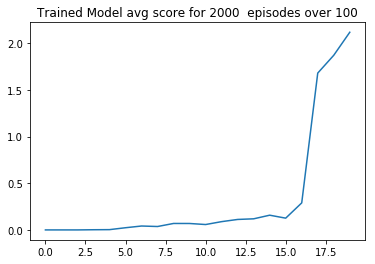

In [16]:
## lets plot over the avg_scores
import matplotlib.pyplot  as plt
%matplotlib inline  
plt.plot(avg_scrores)
plt.title('Trained Model avg score for 2000  episodes over 100')
plt.show()

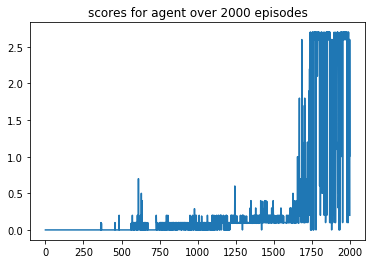

In [17]:
## lets plot over the scores
import matplotlib.pyplot  as plt
%matplotlib inline  
plt.plot(scores_overall)
plt.title('scores for agent over 2000 episodes')
plt.show()

In [18]:
### lets make test run
from Agent import Agent_multi
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def trained_qmodel_run(env):
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
    # env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations  # get the current state (for each agent)
    num_agents = len(env_info.agents)
    state_size = states.shape[1]
    action_size = brain.vector_action_space_size
    agent = Agent_multi(state_size=state_size, action_size=action_size, number_agents=num_agents, random_seed=10,
                        sigma=0.05)
    scores = np.zeros(num_agents)
    action_size = brain.vector_action_space_size
    #print('Size of each action:', action_size)
    # initialize the score (for each agent)
    count = 0
    scores = np.zeros(num_agents)
    while True:
        actions = agent.trained_act(states)  # select an action (for each agent)
        env_info = env.step(actions)[brain_name]  # send all actions to tne environment
        next_states = env_info.vector_observations  # get next state (for each agent)
        rewards = env_info.rewards  # get reward (for each agent)
        dones = env_info.local_done  # see if episode finished
        scores += env_info.rewards  # update the score (for each agent)
        states = next_states  # roll over states to next time step
        if np.any(dones):  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {} , individual scores: {}'.format(np.max(scores),scores))

In [19]:
for i in range(10):
    trained_qmodel_run(env)



Total score (averaged over agents) this episode: 0.5000000074505806 , individual scores: [ 0.50000001  0.39000001]
Total score (averaged over agents) this episode: 0.5000000074505806 , individual scores: [ 0.50000001  0.49000001]
Total score (averaged over agents) this episode: 0.5900000091642141 , individual scores: [ 0.50000001  0.59000001]
Total score (averaged over agents) this episode: 0.5900000091642141 , individual scores: [ 0.50000001  0.59000001]
Total score (averaged over agents) this episode: 0.5900000091642141 , individual scores: [ 0.50000001  0.59000001]
Total score (averaged over agents) this episode: 0.9000000134110451 , individual scores: [ 0.89000001  0.90000001]
Total score (averaged over agents) this episode: 1.0000000149011612 , individual scores: [ 1.00000001  0.89000001]
Total score (averaged over agents) this episode: 1.1900000181049109 , individual scores: [ 1.10000002  1.19000002]
Total score (averaged over agents) this episode: 0.800000011920929 , individual 